# Paralelní výpočty

Paralelní výpočty jsou v dnešním mnohajádrovém světě, kte cluster, cloud, GPU, multi-threading apod. jsou všude, téměř nevyhnutelné. Python nám nabízí nemálo možností pro jejich využítí. Existují ovšem i některá zásadní omezení.
<!-- TEASER_END -->

## Kdy (a jak) paralelizovat
Ještě více než pro optimalizaci platí pro paralelizaci, že vždy *paralelizujeme jen po předchozí analýze funkčního (sekvenčního) programu a jen nutné části programu*. Navíc se vždy snažíme využít (trapně) jednoduchých paralelismů (embarrassingly parallel) v našem programu.

## Vlákna v (C)Pythonu

CPython má pro vícevláknové (*multi threading*) aplikace jedno velice zásadní omezení ve formě [*GIL - Global Interpreter Lock*](http://docs.python.org/2/c-api/init.html#threads). Ten existuje proto, že CPython interpret jako takový není vláknově bezpečný. Neznamená to ovšem, že vlákna jsou v (C)Pythonu absolutní tabu. Zmiňme předně, že např. [Jython](http://www.jython.org/jythonbook/en/1.0/Concurrency.html) nebo stále oblíbenější [PyPy](http://pypy.org/) jsou vláknově bezpečné(ější). I CPython může vlákna používat, existují tam nakonec moduly `threading` a `thread`. Přímočaře můžeme vlákna použít, pokud náš program obsahuje nějaké blokující input/output (I/O) operace. Takovou operaci lze nechat běžet ve vlákně a spustit při tom jiné vlákno. Navíc, pokud programujeme Python modul v C, lze GIL uvolnit manuálně a více využít vláken.

### Vlákna v NumPy a SciPy

NumPy a SciPy sice běží pouze v CPythonu (existuje sice [NumPyPy](http://buildbot.pypy.org/numpy-status/latest.html), v současnosti je ale stále nekompletní), dokáží ale právě GIL ve správnou chvíli uvolnit a některé výpočty provádět ve více vláknech současně, viz http://wiki.scipy.org/ParallelProgramming. Např. maticový součin (`dot`) toho využívá. Navíc často volají numerické knihovny (BLAS, LAPACK, případně jejich optimalizované verze ATLAS nebo Intel MKL).

In [1]:
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

### Cython.parallel


[`cython.parallel`](http://docs.cython.org/src/userguide/parallelism.html) je poněkud nenápadný modul, který ale ovšem využít vlákna (pomocí OpenMP) poměrně jednoduše. Musíme ovšem pracovat pouze s daty (tj. s proměnnými) a funkcemi mimo CPython interpret. Pak můžeme uvolnit gil, např. pomocí `with nogil` bloku a v něm použít `prange`, tak jako to děláme v následujícím příkladě.

Budeme jednoduše sčítat matice. Výpočet jednoduše paralelizujeme tak, že řádky se mohou sčítat nezávisle. To nám zařídí `prange`. Také si všimněte, že výsledné pole alokujeme předem, což může pro velká pole přinést další zrychlení.
Pozor, při kompilaci musíme použít `-fopenmp`, jinak se vlákna budou ignorovat.

In [2]:
%%cython -f --compile-args=-fopenmp --link-args=-fopenmp
cimport cython
from cython.parallel import parallel, prange, threadid
# import cython.parallel as parallel
import numpy as np
cimport numpy as np

# bez kontroly velikosti polí
@cython.boundscheck(False)
# bez relativního indexování pomocí záporných indexů
@cython.wraparound(False)
cpdef double[:,:] add_arrays_2d_views(double[:,:] buf1, double[:,:] buf2, double[:,:] output=None, int nthreads=2):
    cdef int x, y, inner, outer
    # tuto proměnnou budeme potřebovat v nogil bloku
    cdef int _nthreads = nthreads
    # zkontrolujeme rozměry, jinak hrozí segmentation fault
    assert buf1.shape[0] == buf2.shape[0]
    assert buf1.shape[1] == buf2.shape[1]
    outer = buf1.shape[0]
    inner = buf1.shape[1]
    if output is None:
        output = np.zeros_like(buf1)
    else:
        assert output.shape[0] == buf1.shape[0]
        assert output.shape[1] == buf1.shape[1]
    with nogil, cython.boundscheck(False), cython.wraparound(False):
        for x in prange(outer, schedule='static', num_threads=_nthreads):
            for y in xrange(inner):
                output[x, y] = (buf1[x, y] + buf2[x, y])
    return output

In file included from /Users/kuba/.cache/ipython/cython/_cython_magic_b6b9b7dc54b67138b4ffb3bef67342de.c:775:
In file included from /Users/kuba/mambaforge/envs/python-fjfi/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/kuba/mambaforge/envs/python-fjfi/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/kuba/mambaforge/envs/python-fjfi/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940:
/Users/kuba/mambaforge/envs/python-fjfi/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/Users/kuba/.cache/ipython/cython/_cython_magic_b6b9b7dc54b67138b4ffb3bef67342de.c:2882:23: warning: code will never be executed [-Wunreachable-code]
        if ((1 == 0))

Funkci se nám (doufejme) podařilo implementovat vícevláknově. Bylo to ale za cenu přece jenom nemalé práce navíc, přestože Cython nám práci výrazně zjednodušuje. Je třeba poznamenat, že tato funkce by byla v čistém C obdobně složitá.

Otestujeme vytvořenou funkci pro středně velká pole.

In [3]:
n = 2**13
X = np.random.rand(n, n)
Y = np.random.rand(n, n)
Z = np.zeros_like(X)

Pro jistotu i kontrola správnosti výpočtu.

In [4]:
np.allclose(X+Y, add_arrays_2d_views(X, Y))

True

Změříme čas pro 1, 2 a 4 vlákna. Měli bychom vidět zrychlení, záleží na procesoru, arhitektuře, kompilátoru apod.

In [5]:
%timeit add_arrays_2d_views(X, Y, Z, nthreads=1)

27 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%timeit add_arrays_2d_views(X, Y, Z, nthreads=2)

13.9 ms ± 302 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%timeit add_arrays_2d_views(X, Y, Z, nthreads=4)

12.3 ms ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Multiprocessing

Python obsahuje vestavěnou knihovnu [`multiprocessing`](http://docs.python.org/2/library/multiprocessing.html), která poskytuje podobné služby jako vlákna, místo vláken ovšem používá procesy. To má své výhody i nevýhody. Výhodou je jednoduchost a bezpečnost -- pokud spadne jeden proces, ostatní mohou běžet dál. Hlavní nevýhodou (i když z hlediska bezpečnost je to výhoda) jsou oddělené paměťové prostory. (Pokud samozřejmě nepoužijeme sdílenou paměť na úrovni operačního systému.) To znamená, že je třeba co nejméně mezi procesy komunikovat. Ideálně se tato architektura hodí na map-reduce algoritmy, které jsme už zmínili dříve ve funkcionálním programování.

Ukážeme si multiprocessing na velice jednoduchém příkladu, kde procesy se budou pouze identifikovat.

In [8]:
import multiprocessing
import os

In [9]:
%%file my_tasks.py

import os

def task(args):
    return os.getpid(), args

Overwriting my_tasks.py


In [10]:
import my_tasks

my_tasks.task("test")

(74184, 'test')

In [11]:
pool = multiprocessing.Pool(processes=4)

In [12]:
result = pool.map(my_tasks.task, range(1, 9))
result

[(74290, 1),
 (74291, 2),
 (74292, 3),
 (74293, 4),
 (74290, 5),
 (74292, 6),
 (74291, 7),
 (74290, 8)]

## ipyparallel (dříve IPython parallel)

Ipython nám přináší (jak je jeho dobrým zvykem) velice užitečný a všestranný [nástroj na paralelní výpočty](https://ipyparallel.readthedocs.io/en/latest/), který se navíc snadno používá. S použitím message passing a technologie, která byla vyvinuta pro Qt konzoli a následně notebook, přidává `ipyparallel` ještě scheduler a hub, které ovládají a komunikují s klienty a jednotlivými Python procesy (engine).

<img src="https://ipyparallel.readthedocs.io/en/latest/_images/wideView.png" alt="ipyparallel architecture" style="width: 300px;"/>

### Startujeme cluster
Abychom mohli začít tento nástroj používat, musíme nastartovat procesy, ve kterých se budou provádět výpočty. Nejjednodušší je to pomocí nástroje `ipcluster` (ten se spouští v konzoli, nikoli v Pythonu)

    $ ipcluster start -n 4

To nám spustí 4 procesy na jednom počítači. Případně můžeme použít IPython Dashboard -- úvodní stránky Jupyter Notebook.
<!-- <img src="./snapshot_ipynbcluster.png" alt="Cluster from Notebook" style="width: 300px;"/> -->
IPython cluster můžeme spustit i na více počítačích, a to pomocí ssh, mpi, různých batch systémů (PBS, Torque apod.). Můžeme použít i Amazon EC2.

### Používáme cluster
Jakmile jsme nastartovali cluster, můžeme ho začít používat z našeho Python programu. K tomu slouží třída `IPython.parallel.Client`.

In [ ]:
from ipyparallel import Client

In [19]:
cli = Client()

Pomocí atributu `ids` se můžeme dozvědět, jaké prostředky máme k dispozici.

In [20]:
cli.ids

[0, 1, 2, 3]

Každý z těchto procesů můžeme přímo použít pro spuštění nějaké úlohy. Zkusme nejdřív zjistit id procesu z pohledu operačního systému.

In [21]:
def getpid():
    """ return the unique ID of the current process """
    import os
    return os.getpid()

In [22]:
getpid()

2493

Nyní můžeme stejný příkaz spustit na jednom vzdáleném procesu pomocí metody `apply_sync`.

In [23]:
cli[0].apply_sync(getpid)

2580

Velice jednoduše můžeme to samé udělat pro celý cluster.

In [24]:
cli[:].apply_sync(getpid)

[2580, 2581, 2582, 2583]

`cli[:]` nám vlastně vytvořilo objekt `DirectView`, jakýsi (přímý) pohled na cluster. Pro paralelní spuštění můžeme např. použít metodu `map_sync`, což je obdoba `multiprocessing.Pool.map`.

In [25]:
dview = cli[:]
dview.map_sync(lambda x: x**10, range(16))

[0,
 1,
 1024,
 59049,
 1048576,
 9765625,
 60466176,
 282475249,
 1073741824,
 3486784401,
 10000000000,
 25937424601,
 61917364224,
 137858491849,
 289254654976,
 576650390625]

Můžeme použít i dekorátory `parallel` a `remote`. Definujeme teď funkci, která čeká danou dobu (to nám nahradí nějaký delší výpočet).

In [26]:
@dview.parallel(block=True)
def dummy_task(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()

    return [pid, t0, t1]

`dview.parallel` dekorátor způsobil, že dummy_task má metodu `map`, která spustí funkci paralelně na množinu vstupů. Použití je následující.

In [27]:
# Vygenerujeme několik náhodných časů
delay_times = numpy.random.rand(4)
# a můžeme použít map
dummy_task.map(delay_times)

[[2580, 1487081563.2175128, 1487081563.6187928],
 [2581, 1487081563.2196243, 1487081564.1984928],
 [2582, 1487081563.2139854, 1487081563.4248705],
 [2583, 1487081563.2320647, 1487081563.75292]]

Vidíme, že jsme dostali množinu výsledků, které byly spočítány v různých procesech.

Pojďme zkusit vizualizovat zatížení jednotlivých procesů. Použijeme k tomu více vstupů a jednoduchou funkci, která vytvoří jednoduchý graf.

In [28]:
def visualize_tasks(results):
    res = numpy.array(results)
    fig, ax = subplots(figsize=(10, res.shape[1]))

    yticks = []
    yticklabels = []
    tmin = min(res[:,1])
    for n, pid in enumerate(numpy.unique(res[:,0])):
        yticks.append(n)
        yticklabels.append("%d" % pid)
        for m in numpy.where(res[:,0] == pid)[0]:
            ax.add_patch(Rectangle((res[m,1] - tmin, n-0.25),
                         res[m,2] - res[m,1], 0.5, color="green", alpha=0.5))

    ax.set_ylim(-.5, n+.5)
    ax.set_xlim(0, max(res[:,2]) - tmin + 0.)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("PID")
    ax.set_xlabel("seconds")

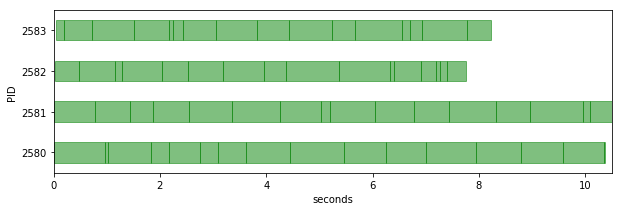

In [29]:
delay_times = numpy.random.rand(64)
results = dummy_task.map(delay_times)
visualize_tasks(results)

Tady vidíme, že jsme poměrně dobře vytížili všechny čtyři procesy pomocí poměrně jednoduché paralelizace. Ještě lepšího výsledku můžeme dosáhnout pomocí `LoadBalancedView`. Tato třída, na rozdíl od `DirectView`, rozděluje úlohy dynamicky podle zatížení jednotlivých procesů.

`LoadBalancedView` dostaneme jednoduše pomocí `load_balanced_view`:

In [30]:
lbview = cli.load_balanced_view()

Nyní definujeme stejnou funkci jako dummy_task, jen pomocí LoadBalancedView dekorátoru.

In [31]:
@lbview.parallel(block=True)
def dummy_task_load_balanced(delay):
    """ a dummy task that takes 'delay' seconds to finish """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()

    return [pid, t0, t1]

A zkusíme opět nakreslit graf využití procesorů.

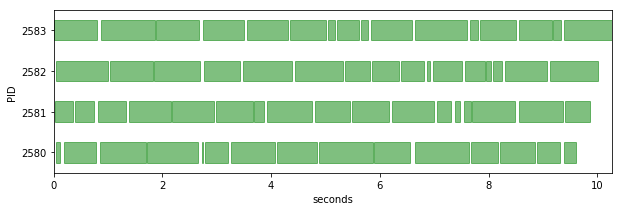

In [32]:
result = dummy_task_load_balanced.map(delay_times)
visualize_tasks(result)

Vidíme, že jsme rovnoměrněji zatížili náš cluster a dasáhli o něco kratšího celkového času pro výpočet.

### Více najdete v dokumentaci
ipyparallel nabízí ještě mnohem více, např.

* paralelní triky (`%px` apod.)
* asynchronní (neblokující) spouštění
* použití MPI
* ..., viz https://ipyparallel.readthedocs.io/

## MPI

Pro intenzivní komunikaci mezi procesy je třeba použít efektivnějšího řešení, než je komunikace přes IPython controller, kterou jsme doposud používali (aniž bychom o tom nějak více přemýšleli). K tomu účelu obvykle slouží MPI -- Message Passign Interface. MPI je nezávislé na programovacím jazyce, neboť se jedná především o síťový protokol, který umožňuje synchronně nebo asynchronně posílat několik primitivních tipů, a to buď mezi jednotlivými procesy (point to point) nebo hromadně (broadcasting). Implementací je více, mezi běžné patři např. MPICH nebo OpenMPI. Pro Python existuje [mpi4py](http://mpi4py.scipy.org/).

### Jednoduchý příklad

MPI programy je třeba spouštět pomocí `mpirun`. Následující příklady se tedy pro názornost nespouští přímo v notebooku, i když IPython přímé použití MPI také podporuje.

In [33]:
%%file mpitest.py

from mpi4py import MPI
from numpy import arange

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    # rank 0 je ridici proces
    data = ["a", 2.0, 3.0, {"numpy": arange(3)}]
    print("sending data: {}".format(data))
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    # tady bychom provadeli jednotlive vypocty
    data = comm.recv(source=0, tag=11)
    print("received data: {}".format(data))

print("rank {} finished".format(rank))

Writing mpitest.py


Spustíme pomocí mpirun se dvěma procesy.

In [34]:
!mpirun -n 2 python mpitest.py

sending data: ['a', 2.0, 3.0, {'numpy': array([0, 1, 2])}]
rank 0 finished
received data: ['a', 2.0, 3.0, {'numpy': array([0, 1, 2])}]
rank 1 finished


Jak jsme viděli, pomocí `send` můžeme posílat celkem libovolné Python obejkty. Výstup posledního řádku může být přeházený, neboť procesy běží paralelně. Komunikace pomocí `send` je blokující, pro neblokující bychom použili `isend`.

In [35]:
%%file mpitest_async.py

from mpi4py import MPI
from numpy import arange

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

print("rank {} started".format(rank))

if rank == 0:
    # rank 0 je ridici proces
    data = ["a", 2.0, 3.0, {"numpy": arange(3)}]
    print("sending data: {}".format(data))
    req = comm.isend(data, dest=1, tag=11)
    req.Wait()
elif rank == 1:
    # tady bychom provadeli jednotlive vypocty
    data = comm.recv(source=0, tag=11)
    print("received data: {}".format(data))

print("rank {} finished".format(rank))

Writing mpitest_async.py


In [37]:
!mpirun -n 2 python mpitest_async.py

rank 0 started
sending data: ['a', 2.0, 3.0, {'numpy': array([0, 1, 2])}]
rank 0 finished
rank 1 started
received data: ['a', 2.0, 3.0, {'numpy': array([0, 1, 2])}]
rank 1 finished


### Posílání polí apod.
`send` dokáže poslat téměř cokoli, může to ale být neefektivní. Proto existují funkce `Send` and `Recv` (ano, rozdíl je pouze ve velikosti prvních písmen), které dokáží posílat bloky primitivních datových typů. To se velice hodí pro numpy, kde jsou pole uložené právě v takových blocích. Pozor, tady sestupujema na nižší úroveň abstrakce (podobně jako u Cythonu) a musíme daleko více explicitně řešit typy, rozměry, alokace apod.

Pojďme se podívat, jak lze pomocí `Send` a `Recv` poslat numpy pole. Pro numpy pole základních typů můžeme použít automatické rozeznání tohoto typu.

In [38]:
%%file numpy_mpi.py
# from http://mpi4py.scipy.org/docs/usrman/tutorial.html#point-to-point-communication
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

print("rank {} started".format(rank))

# pass explicit MPI datatypes
if rank == 0:
    data = numpy.arange(1000, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = numpy.empty(1000, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)

# automatic MPI datatype discovery
if rank == 0:
    data = numpy.arange(100, dtype=numpy.float64)
    print("rank {}, sum={}".format(rank, data.sum()))
    comm.Send(data, dest=1, tag=13)
elif rank == 1:
    data = numpy.empty(100, dtype=numpy.float64)
    comm.Recv(data, source=0, tag=13)
    print("rank {}, sum={}".format(rank, data.sum()))
print("rank {} finished".format(rank))

Writing numpy_mpi.py


In [40]:
!mpirun -n 6 python numpy_mpi.py

rank 4 started
rank 4 finished
rank 0 started
rank 0, sum=4950.0
rank 0 finished
rank 1 started
rank 1, sum=4950.0
rank 1 finished
rank 5 started
rank 5 finished
rank 3 started
rank 3 finished
rank 2 started
rank 2 finished


## Další možnosti

### Blaze -- blíží se nové NumPy?

Blaze se snaží rozšířit NumPy (nebo spíše vytvořit nové) o paralelní výpočty, heterogenní rozměry, různě uložená data aj. [Dokumentace](http://blaze.pydata.org/docs/index.html) říká

"*Blaze is the next generation of NumPy, Python’s extremely popular array library. Blaze is designed to handle out-of-core computations on large datasets that exceed the system memory capacity, as well as on distributed and streaming data.*

*Blaze will allow analysts and scientists to productively write robust and efficient code, without getting bogged down in the details of how to distribute computation, or worse, how to transport and convert data between databases, formats, proprietary data warehouses, and other silos.*

*The core of Blaze consists of generic multi-dimensional Array and Table objects with an associated type system for expressing all kinds of data types and layouts, especially semi-structured, sparse, and columnar data. Blaze’s generalized calculation engine can iterate over the distributed array or table and dispatch to low-level kernels specialized for the layout and type of the data."*

In [41]:
from blaze import Data

t = Data([(1, 'Alice', 100),
           (2, 'Bob', -200),
           (3, 'Charlie', 300),
           (4, 'Denis', 400),
           (5, 'Edith', -500)],
          fields=['id', 'name', 'balance'])
t

id     name  balance
0   1    Alice      100
1   2      Bob     -200
2   3  Charlie      300
3   4    Denis      400
4   5    Edith     -500

In [42]:
t[t.balance < 0]

id   name  balance
0   2    Bob     -200
1   5  Edith     -500

In [43]:
", ".join((m for m in dir(t) if not m.startswith("_")))

'apply, balance, columns, count, count_values, data, distinct, dshape, fields, head, id, isidentical, map, name, ndim, nelements, nrows, nunique, relabel, schema, shape, shift, sort, tail'

### Výpočty na GPU (GPGPU)
Pro GPU výpočty, což jsou obvykle SIMD (signle instruction multiple data) výpočty na mnoha jádrech, slouží v Pythonu knihovny [PyOpenCL](http://documen.tician.de/pyopencl) a [pyCUDA](http://documen.tician.de/pycuda/). Jen pro ilustraci ukázka PyOpenCL:

In [ ]:
import pyopencl as cl
import numpy
import numpy.linalg as la

a = numpy.random.rand(50000).astype(numpy.float32)
b = numpy.random.rand(50000).astype(numpy.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
b_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)
dest_buf = cl.Buffer(ctx, mf.WRITE_ONLY, b.nbytes)

prg = cl.Program(ctx, """
    __kernel void sum(__global const float *a,
    __global const float *b, __global float *c)
    {
      int gid = get_global_id(0);
      c[gid] = a[gid] + b[gid];
    }
    """).build()

prg.sum(queue, a.shape, None, a_buf, b_buf, dest_buf)

a_plus_b = numpy.empty_like(a)
cl.enqueue_copy(queue, a_plus_b, dest_buf)

print(la.norm(a_plus_b - (a+b)), la.norm(a_plus_b))

### Python + Intel Many Integrated Core Architecture

Intel Many Integrated Core Architecture (MIC) je procesor podobný GPU s x86 instrukcemi. Nedávno byl uceden do prodeje první generace pod názvem Xeon Phi. Zdá se, že Python se podařilo na této architektuře zkompilovat: http://software.intel.com/en-us/forums/topic/392736. V takovém případě lze používat např. vestavěný modul `multiprocessing`.

### ...
Další najdete na https://wiki.python.org/moin/ParallelProcessing.